# Acoustic Navigation Training Notebook

In [1]:
import torch
print("torch:", torch.__version__)
print("built with CUDA:", torch.version.cuda)        # None => CPU-only build
print("cuda available:", torch.cuda.is_available())  # should be True
print("cuda built:", torch.backends.cuda.is_built()) # True if GPU build


torch: 2.9.1+cu126
built with CUDA: 12.6
cuda available: True
cuda built: True


In [2]:
import sys
sys.path.append('../')

import numpy as np
from pathlib import Path
import torch
from torch.utils.data import DataLoader

from src.cave_dataset import (
    MultiCaveDataset,
    ACTION_MAP,
    ACTION_NAMES,
    MIC_OFFSETS,
    compute_class_distribution,
    compute_class_weights,
)
from src.models import FocalLoss, WavefrontNet, WideFieldNet
from src.lmdb_dataset import LMDBAcousticDataset

print(torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
np.random.seed(42)
torch.manual_seed(42)

2.9.1+cu126
Using device: cuda


In [3]:
# Cell 4+5: Perfectly Balanced Dataset (FIXED SEED)
# ---------------------------------------------------------
import numpy as np
import torch
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import random
from pathlib import Path
from collections import defaultdict
from src.lmdb_dataset import LMDBAcousticDataset 

# --- CRITICAL FIX: Seed Python's Random Generator ---
# This ensures we pick the EXACT same 2,300 samples every time.
random.seed(42) 
np.random.seed(42)
torch.manual_seed(42)

# 1. Load Raw Data
DATASET_DIR = Path('D:/audiomaze_dataset')
raw_dataset = LMDBAcousticDataset('D:/audiomaze_lmdb')

# 2. Scan and Sort Indices by Class
print("Scanning dataset to group indices by class...")
indices_by_class = defaultdict(list)

for idx in range(len(raw_dataset)):
    _, action, _, _ = raw_dataset[idx]
    act = int(action)
    if act in [1, 2, 3, 4]: # 1=UP, 2=DOWN, 3=LEFT, 4=RIGHT
        indices_by_class[act].append(idx)

# 3. Dynamic Downsampling
min_count = min(len(indices_by_class[c]) for c in [1, 2, 3, 4])
print(f"\nClass Counts: { {k: len(v) for k,v in indices_by_class.items()} }")
print(f"--> Downsampling to: {min_count} samples per class")

# 4. Create Perfectly Balanced Index List
balanced_indices = []
for cls in [1, 2, 3, 4]:
    # Now this sampling is DETERMINISTIC due to random.seed(42)
    sampled = random.sample(indices_by_class[cls], min_count)
    balanced_indices.extend(sampled)

random.shuffle(balanced_indices)

# 5. Create Dataset & Split
balanced_dataset = Subset(raw_dataset, balanced_indices)
balanced_targets = [raw_dataset[i][1].item() for i in balanced_indices]

train_idx, val_idx = train_test_split(
    np.arange(len(balanced_dataset)), 
    test_size=0.2, 
    random_state=42, 
    stratify=balanced_targets
)

train_dataset = Subset(balanced_dataset, train_idx)
val_dataset = Subset(balanced_dataset, val_idx)

# 6. Loaders
# Lower batch size (128) helps generalization on small datasets
BATCH_SIZE = 512
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"\n✅ Data Ready (Deterministic):")
print(f"  Train: {len(train_dataset)} samples")
print(f"  Val:   {len(val_dataset)} samples")

c:\Users\danyi\repo\Audio-Maze-Navigation\.venv\Lib\site-packages\sklearn\utils\_param_validation.py:14: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 2.3.5)
  from scipy.sparse import csr_matrix, issparse


Loaded LMDB dataset: 98,856 samples
Action distribution: {'down': 24464, 'right': 24464, 'left': 24464, 'up': 24464, 'stop': 1000}
Scanning dataset to group indices by class...

Class Counts: {2: 24464, 4: 24464, 3: 24464, 1: 24464}
--> Downsampling to: 24464 samples per class

✅ Data Ready (Deterministic):
  Train: 78284 samples
  Val:   19572 samples


In [4]:
# Cell 6: Model Initialization (WavefrontNet - 2D)
# ---------------------------------------------------------
import torch
import torch.nn as nn
from src.models import WavefrontNet  # Import the new 2D model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the 2D Architecture
model = WavefrontNet(num_classes=4, dropout=0.5).to(device)

# 1e-3 is the "Aggressive" LR that worked for the 2D model
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)
criterion = torch.nn.CrossEntropyLoss()

print("✅ WavefrontNet (2D) Loaded from src.models")
print(f"   Device: {device}")
print(f"   Parameters: {sum(p.numel() for p in model.parameters()):,}")

✅ WavefrontNet (2D) Loaded from src.models
   Device: cuda
   Parameters: 565,668


In [5]:
# Cell 7: Training Loop (With Augmentation & Regularization)
# ---------------------------------------------------------
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import numpy as np
from pathlib import Path
from contextlib import nullcontext

# --- CONFIGURATION UPDATES ---
EPOCHS = 100          # Need more epochs because augmentation makes training harder
LR = 0.001           # Keep aggressive start
WEIGHT_DECAY = 0.1   # Increased from 0.01 to 0.1 (Strong Regularization)

save_dir = Path("checkpoints")
save_dir.mkdir(parents=True, exist_ok=True)
best_val_acc = 0.0

# History
history = {'train_loss': [], 'train_acc': [], 'val_acc': []}

# --- AUGMENTATION ENGINE ---
class AudioAugmenter(nn.Module):
    def __init__(self, shift_limit=2000, noise_level=0.05):
        super().__init__()
        self.shift_limit = shift_limit
        self.noise_level = noise_level

    def forward(self, x):
        # x shape: [Batch, 8, Time]
        if not self.training: return x
        
        # 1. Time Shift (Roll)
        # We roll the time axis (dim 2). Slope direction is preserved!
        shift = torch.randint(-self.shift_limit, self.shift_limit, (1,)).item()
        x = torch.roll(x, shifts=shift, dims=2)
        
        # 2. Gaussian Noise Injection
        noise = torch.randn_like(x) * self.noise_level * x.std(dim=(1,2), keepdim=True)
        x = x + noise
        
        return x

augmenter = AudioAugmenter(shift_limit=1500, noise_level=0.05).to(device)

# --- OPTIMIZER & LOSS ---
# 1. Stronger Weight Decay prevents weights from growing too large (memorization)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=5, min_lr=1e-6
)

# 2. Label Smoothing: Prevents the model from becoming "Over-Confident" (100% probability)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# AMP Setup
scaler = torch.amp.GradScaler('cuda') if torch.cuda.is_available() else torch.amp.GradScaler(enabled=False)
autocast_ctx = lambda: torch.amp.autocast('cuda') if torch.cuda.is_available() else nullcontext()

print("=" * 60)
print(f"STARTING AUGMENTED TRAINING")
print(f"   Config: Shifts=+/-1500 | Noise=5% | Decay={WEIGHT_DECAY} | LabelSmooth=0.1")
print("=" * 60)

for epoch in range(EPOCHS):
    model.train()
    augmenter.train() # Enable augmentation
    
    train_correct = 0
    train_total = 0
    train_loss = 0
    
    pbar = tqdm(train_loader, desc=f"Ep {epoch+1}/{EPOCHS}", dynamic_ncols=True, colour="#FF9800")
    for mic, action, _, _ in pbar:
        mic = mic.to(device, non_blocking=True)
        targets = (action - 1).to(device, non_blocking=True)
        
        optimizer.zero_grad(set_to_none=True)
        
        with autocast_ctx():
            # --- APPLY AUGMENTATION ---
            mic_aug = augmenter(mic)
            
            logits = model(mic_aug)
            loss = criterion(logits, targets)
            
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()
        preds = logits.argmax(dim=1)
        train_correct += (preds == targets).sum().item()
        train_total += targets.numel()
        
        pbar.set_postfix(loss=train_loss/train_total, acc=train_correct/train_total)

    # Record Stats
    avg_train_loss = train_loss / len(train_loader)
    avg_train_acc = train_correct / train_total
    history['train_loss'].append(avg_train_loss)
    history['train_acc'].append(avg_train_acc)

    # --- VALIDATION (No Augmentation) ---
    model.eval()
    augmenter.eval() # Disable augmentation
    
    val_correct = 0
    val_total = 0
    val_pred_counts = {0:0, 1:0, 2:0, 3:0} 
    
    with torch.no_grad():
        for mic, action, _, _ in val_loader:
            mic = mic.to(device, non_blocking=True)
            targets = (action - 1).to(device)

            with autocast_ctx():
                logits = model(mic)
            
            preds = logits.argmax(dim=1)
            val_correct += (preds == targets).sum().item()
            val_total += targets.numel()
            
            for p in preds.tolist():
                val_pred_counts[p] += 1

    avg_val_acc = val_correct / val_total
    history['val_acc'].append(avg_val_acc)
    
    scheduler.step(avg_val_acc)
    
    # Distribution Check
    total_preds = sum(val_pred_counts.values())
    dist_str = " | ".join([f"{k}:{v/total_preds:.0%}" for k,v in val_pred_counts.items()])
    
    print(f"\nSummary Ep {epoch+1}: Val Acc {avg_val_acc:.3f} | Train Acc {avg_train_acc:.3f} | LR: {optimizer.param_groups[0]['lr']:.2e}")
    print(f"  Pred Distribution: {dist_str}")
    
    if avg_val_acc > best_val_acc:
        best_val_acc = avg_val_acc
        torch.save(model.state_dict(), save_dir / "best_model_wavefront_aug.pt")
        print("  --> Saved Best Model")
        
    print("-" * 60)

STARTING AUGMENTED TRAINING
   Config: Shifts=+/-1500 | Noise=5% | Decay=0.1 | LabelSmooth=0.1


Ep 1/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 1: Val Acc 0.267 | Train Acc 0.327 | LR: 1.00e-03
  Pred Distribution: 0:94% | 1:0% | 2:3% | 3:3%
  --> Saved Best Model
------------------------------------------------------------


Ep 2/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 2: Val Acc 0.302 | Train Acc 0.361 | LR: 1.00e-03
  Pred Distribution: 0:0% | 1:56% | 2:0% | 3:44%
  --> Saved Best Model
------------------------------------------------------------


Ep 3/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 3: Val Acc 0.281 | Train Acc 0.380 | LR: 1.00e-03
  Pred Distribution: 0:0% | 1:21% | 2:0% | 3:79%
------------------------------------------------------------


Ep 4/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 4: Val Acc 0.293 | Train Acc 0.400 | LR: 1.00e-03
  Pred Distribution: 0:87% | 1:2% | 2:1% | 3:11%
------------------------------------------------------------


Ep 5/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 5: Val Acc 0.266 | Train Acc 0.413 | LR: 1.00e-03
  Pred Distribution: 0:0% | 1:6% | 2:0% | 3:94%
------------------------------------------------------------


Ep 6/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 6: Val Acc 0.336 | Train Acc 0.425 | LR: 1.00e-03
  Pred Distribution: 0:71% | 1:4% | 2:5% | 3:21%
  --> Saved Best Model
------------------------------------------------------------


Ep 7/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 7: Val Acc 0.268 | Train Acc 0.436 | LR: 1.00e-03
  Pred Distribution: 0:95% | 1:0% | 2:1% | 3:4%
------------------------------------------------------------


Ep 8/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 8: Val Acc 0.368 | Train Acc 0.441 | LR: 1.00e-03
  Pred Distribution: 0:65% | 1:10% | 2:12% | 3:12%
  --> Saved Best Model
------------------------------------------------------------


Ep 9/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 9: Val Acc 0.342 | Train Acc 0.450 | LR: 1.00e-03
  Pred Distribution: 0:31% | 1:3% | 2:0% | 3:66%
------------------------------------------------------------


Ep 10/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 10: Val Acc 0.389 | Train Acc 0.457 | LR: 1.00e-03
  Pred Distribution: 0:19% | 1:26% | 2:4% | 3:51%
  --> Saved Best Model
------------------------------------------------------------


Ep 11/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 11: Val Acc 0.309 | Train Acc 0.467 | LR: 1.00e-03
  Pred Distribution: 0:1% | 1:15% | 2:1% | 3:82%
------------------------------------------------------------


Ep 12/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 12: Val Acc 0.307 | Train Acc 0.475 | LR: 1.00e-03
  Pred Distribution: 0:0% | 1:80% | 2:19% | 3:1%
------------------------------------------------------------


Ep 13/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 13: Val Acc 0.418 | Train Acc 0.486 | LR: 1.00e-03
  Pred Distribution: 0:18% | 1:34% | 2:6% | 3:42%
  --> Saved Best Model
------------------------------------------------------------


Ep 14/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 14: Val Acc 0.282 | Train Acc 0.489 | LR: 1.00e-03
  Pred Distribution: 0:8% | 1:1% | 2:0% | 3:91%
------------------------------------------------------------


Ep 15/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 15: Val Acc 0.429 | Train Acc 0.498 | LR: 1.00e-03
  Pred Distribution: 0:49% | 1:23% | 2:12% | 3:17%
  --> Saved Best Model
------------------------------------------------------------


Ep 16/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 16: Val Acc 0.304 | Train Acc 0.507 | LR: 1.00e-03
  Pred Distribution: 0:0% | 1:18% | 2:0% | 3:82%
------------------------------------------------------------


Ep 17/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 17: Val Acc 0.310 | Train Acc 0.517 | LR: 1.00e-03
  Pred Distribution: 0:3% | 1:12% | 2:1% | 3:83%
------------------------------------------------------------


Ep 18/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 18: Val Acc 0.420 | Train Acc 0.524 | LR: 1.00e-03
  Pred Distribution: 0:49% | 1:9% | 2:10% | 3:32%
------------------------------------------------------------


Ep 19/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 19: Val Acc 0.360 | Train Acc 0.532 | LR: 1.00e-03
  Pred Distribution: 0:58% | 1:1% | 2:0% | 3:40%
------------------------------------------------------------


Ep 20/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 20: Val Acc 0.386 | Train Acc 0.545 | LR: 1.00e-03
  Pred Distribution: 0:29% | 1:2% | 2:8% | 3:61%
------------------------------------------------------------


Ep 21/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 21: Val Acc 0.368 | Train Acc 0.550 | LR: 5.00e-04
  Pred Distribution: 0:1% | 1:8% | 2:17% | 3:74%
------------------------------------------------------------


Ep 22/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 22: Val Acc 0.494 | Train Acc 0.573 | LR: 5.00e-04
  Pred Distribution: 0:14% | 1:29% | 2:27% | 3:30%
  --> Saved Best Model
------------------------------------------------------------


Ep 23/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 23: Val Acc 0.337 | Train Acc 0.585 | LR: 5.00e-04
  Pred Distribution: 0:2% | 1:78% | 2:1% | 3:19%
------------------------------------------------------------


Ep 24/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 24: Val Acc 0.487 | Train Acc 0.593 | LR: 5.00e-04
  Pred Distribution: 0:10% | 1:18% | 2:27% | 3:45%
------------------------------------------------------------


Ep 25/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 25: Val Acc 0.439 | Train Acc 0.599 | LR: 5.00e-04
  Pred Distribution: 0:45% | 1:5% | 2:39% | 3:11%
------------------------------------------------------------


Ep 26/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 26: Val Acc 0.451 | Train Acc 0.606 | LR: 5.00e-04
  Pred Distribution: 0:48% | 1:12% | 2:8% | 3:32%
------------------------------------------------------------


Ep 27/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 27: Val Acc 0.478 | Train Acc 0.611 | LR: 5.00e-04
  Pred Distribution: 0:14% | 1:42% | 2:31% | 3:13%
------------------------------------------------------------


Ep 28/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 28: Val Acc 0.388 | Train Acc 0.618 | LR: 2.50e-04
  Pred Distribution: 0:67% | 1:1% | 2:5% | 3:26%
------------------------------------------------------------


Ep 29/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 29: Val Acc 0.475 | Train Acc 0.632 | LR: 2.50e-04
  Pred Distribution: 0:54% | 1:12% | 2:15% | 3:19%
------------------------------------------------------------


Ep 30/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 30: Val Acc 0.503 | Train Acc 0.638 | LR: 2.50e-04
  Pred Distribution: 0:30% | 1:38% | 2:14% | 3:18%
  --> Saved Best Model
------------------------------------------------------------


Ep 31/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 31: Val Acc 0.528 | Train Acc 0.640 | LR: 2.50e-04
  Pred Distribution: 0:26% | 1:18% | 2:28% | 3:28%
  --> Saved Best Model
------------------------------------------------------------


Ep 32/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 32: Val Acc 0.495 | Train Acc 0.647 | LR: 2.50e-04
  Pred Distribution: 0:42% | 1:8% | 2:30% | 3:20%
------------------------------------------------------------


Ep 33/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 33: Val Acc 0.510 | Train Acc 0.651 | LR: 2.50e-04
  Pred Distribution: 0:24% | 1:12% | 2:43% | 3:21%
------------------------------------------------------------


Ep 34/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 34: Val Acc 0.498 | Train Acc 0.653 | LR: 2.50e-04
  Pred Distribution: 0:22% | 1:14% | 2:19% | 3:45%
------------------------------------------------------------


Ep 35/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 35: Val Acc 0.515 | Train Acc 0.656 | LR: 2.50e-04
  Pred Distribution: 0:34% | 1:19% | 2:14% | 3:32%
------------------------------------------------------------


Ep 36/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 36: Val Acc 0.513 | Train Acc 0.658 | LR: 2.50e-04
  Pred Distribution: 0:29% | 1:28% | 2:13% | 3:30%
------------------------------------------------------------


Ep 37/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 37: Val Acc 0.516 | Train Acc 0.662 | LR: 1.25e-04
  Pred Distribution: 0:9% | 1:13% | 2:36% | 3:42%
------------------------------------------------------------


Ep 38/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 38: Val Acc 0.537 | Train Acc 0.669 | LR: 1.25e-04
  Pred Distribution: 0:23% | 1:25% | 2:18% | 3:34%
  --> Saved Best Model
------------------------------------------------------------


Ep 39/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 39: Val Acc 0.526 | Train Acc 0.675 | LR: 1.25e-04
  Pred Distribution: 0:32% | 1:8% | 2:34% | 3:25%
------------------------------------------------------------


Ep 40/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 40: Val Acc 0.544 | Train Acc 0.677 | LR: 1.25e-04
  Pred Distribution: 0:25% | 1:30% | 2:23% | 3:22%
  --> Saved Best Model
------------------------------------------------------------


Ep 41/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 41: Val Acc 0.550 | Train Acc 0.677 | LR: 1.25e-04
  Pred Distribution: 0:26% | 1:18% | 2:30% | 3:27%
  --> Saved Best Model
------------------------------------------------------------


Ep 42/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 42: Val Acc 0.537 | Train Acc 0.677 | LR: 1.25e-04
  Pred Distribution: 0:31% | 1:30% | 2:21% | 3:18%
------------------------------------------------------------


Ep 43/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 43: Val Acc 0.540 | Train Acc 0.679 | LR: 1.25e-04
  Pred Distribution: 0:27% | 1:17% | 2:36% | 3:20%
------------------------------------------------------------


Ep 44/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 44: Val Acc 0.551 | Train Acc 0.681 | LR: 1.25e-04
  Pred Distribution: 0:23% | 1:18% | 2:32% | 3:27%
  --> Saved Best Model
------------------------------------------------------------


Ep 45/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 45: Val Acc 0.549 | Train Acc 0.685 | LR: 1.25e-04
  Pred Distribution: 0:26% | 1:18% | 2:25% | 3:32%
------------------------------------------------------------


Ep 46/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 46: Val Acc 0.534 | Train Acc 0.683 | LR: 1.25e-04
  Pred Distribution: 0:30% | 1:19% | 2:34% | 3:17%
------------------------------------------------------------


Ep 47/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 47: Val Acc 0.542 | Train Acc 0.686 | LR: 1.25e-04
  Pred Distribution: 0:18% | 1:25% | 2:37% | 3:19%
------------------------------------------------------------


Ep 48/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 48: Val Acc 0.530 | Train Acc 0.688 | LR: 1.25e-04
  Pred Distribution: 0:24% | 1:23% | 2:38% | 3:16%
------------------------------------------------------------


Ep 49/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 49: Val Acc 0.535 | Train Acc 0.688 | LR: 1.25e-04
  Pred Distribution: 0:36% | 1:24% | 2:24% | 3:16%
------------------------------------------------------------


Ep 50/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 50: Val Acc 0.541 | Train Acc 0.690 | LR: 6.25e-05
  Pred Distribution: 0:23% | 1:25% | 2:17% | 3:35%
------------------------------------------------------------


Ep 51/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 51: Val Acc 0.557 | Train Acc 0.694 | LR: 6.25e-05
  Pred Distribution: 0:30% | 1:22% | 2:22% | 3:26%
  --> Saved Best Model
------------------------------------------------------------


Ep 52/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 52: Val Acc 0.538 | Train Acc 0.694 | LR: 6.25e-05
  Pred Distribution: 0:23% | 1:18% | 2:40% | 3:19%
------------------------------------------------------------


Ep 53/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 53: Val Acc 0.555 | Train Acc 0.696 | LR: 6.25e-05
  Pred Distribution: 0:27% | 1:23% | 2:21% | 3:29%
------------------------------------------------------------


Ep 54/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 54: Val Acc 0.559 | Train Acc 0.697 | LR: 6.25e-05
  Pred Distribution: 0:22% | 1:18% | 2:30% | 3:31%
  --> Saved Best Model
------------------------------------------------------------


Ep 55/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 55: Val Acc 0.557 | Train Acc 0.695 | LR: 6.25e-05
  Pred Distribution: 0:28% | 1:22% | 2:22% | 3:28%
------------------------------------------------------------


Ep 56/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 56: Val Acc 0.540 | Train Acc 0.698 | LR: 6.25e-05
  Pred Distribution: 0:24% | 1:17% | 2:39% | 3:20%
------------------------------------------------------------


Ep 57/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 57: Val Acc 0.544 | Train Acc 0.697 | LR: 6.25e-05
  Pred Distribution: 0:31% | 1:28% | 2:24% | 3:17%
------------------------------------------------------------


Ep 58/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 58: Val Acc 0.547 | Train Acc 0.701 | LR: 6.25e-05
  Pred Distribution: 0:21% | 1:29% | 2:19% | 3:31%
------------------------------------------------------------


Ep 59/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 59: Val Acc 0.559 | Train Acc 0.700 | LR: 6.25e-05
  Pred Distribution: 0:28% | 1:21% | 2:25% | 3:26%
  --> Saved Best Model
------------------------------------------------------------


Ep 60/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 60: Val Acc 0.558 | Train Acc 0.702 | LR: 6.25e-05
  Pred Distribution: 0:23% | 1:28% | 2:27% | 3:23%
------------------------------------------------------------


Ep 61/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 61: Val Acc 0.560 | Train Acc 0.702 | LR: 6.25e-05
  Pred Distribution: 0:24% | 1:21% | 2:30% | 3:26%
  --> Saved Best Model
------------------------------------------------------------


Ep 62/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 62: Val Acc 0.542 | Train Acc 0.703 | LR: 6.25e-05
  Pred Distribution: 0:23% | 1:29% | 2:32% | 3:15%
------------------------------------------------------------


Ep 63/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 63: Val Acc 0.564 | Train Acc 0.702 | LR: 6.25e-05
  Pred Distribution: 0:26% | 1:22% | 2:27% | 3:25%
  --> Saved Best Model
------------------------------------------------------------


Ep 64/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 64: Val Acc 0.559 | Train Acc 0.706 | LR: 6.25e-05
  Pred Distribution: 0:29% | 1:15% | 2:28% | 3:27%
------------------------------------------------------------


Ep 65/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 65: Val Acc 0.562 | Train Acc 0.705 | LR: 6.25e-05
  Pred Distribution: 0:27% | 1:21% | 2:28% | 3:24%
------------------------------------------------------------


Ep 66/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 66: Val Acc 0.538 | Train Acc 0.705 | LR: 6.25e-05
  Pred Distribution: 0:36% | 1:15% | 2:17% | 3:32%
------------------------------------------------------------


Ep 67/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 67: Val Acc 0.549 | Train Acc 0.704 | LR: 6.25e-05
  Pred Distribution: 0:24% | 1:30% | 2:18% | 3:28%
------------------------------------------------------------


Ep 68/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 68: Val Acc 0.559 | Train Acc 0.707 | LR: 6.25e-05
  Pred Distribution: 0:23% | 1:19% | 2:34% | 3:23%
------------------------------------------------------------


Ep 69/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 69: Val Acc 0.562 | Train Acc 0.708 | LR: 3.13e-05
  Pred Distribution: 0:23% | 1:24% | 2:29% | 3:24%
------------------------------------------------------------


Ep 70/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 70: Val Acc 0.562 | Train Acc 0.708 | LR: 3.13e-05
  Pred Distribution: 0:29% | 1:22% | 2:23% | 3:26%
------------------------------------------------------------


Ep 71/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 71: Val Acc 0.563 | Train Acc 0.710 | LR: 3.13e-05
  Pred Distribution: 0:22% | 1:24% | 2:30% | 3:24%
------------------------------------------------------------


Ep 72/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 72: Val Acc 0.560 | Train Acc 0.709 | LR: 3.13e-05
  Pred Distribution: 0:22% | 1:26% | 2:28% | 3:24%
------------------------------------------------------------


Ep 73/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 73: Val Acc 0.561 | Train Acc 0.711 | LR: 3.13e-05
  Pred Distribution: 0:24% | 1:24% | 2:28% | 3:24%
------------------------------------------------------------


Ep 74/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 74: Val Acc 0.557 | Train Acc 0.711 | LR: 3.13e-05
  Pred Distribution: 0:24% | 1:21% | 2:22% | 3:33%
------------------------------------------------------------


Ep 75/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 75: Val Acc 0.565 | Train Acc 0.711 | LR: 3.13e-05
  Pred Distribution: 0:27% | 1:22% | 2:26% | 3:25%
  --> Saved Best Model
------------------------------------------------------------


Ep 76/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 76: Val Acc 0.562 | Train Acc 0.713 | LR: 3.13e-05
  Pred Distribution: 0:26% | 1:25% | 2:23% | 3:26%
------------------------------------------------------------


Ep 77/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 77: Val Acc 0.561 | Train Acc 0.713 | LR: 3.13e-05
  Pred Distribution: 0:29% | 1:18% | 2:26% | 3:27%
------------------------------------------------------------


Ep 78/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 78: Val Acc 0.562 | Train Acc 0.712 | LR: 3.13e-05
  Pred Distribution: 0:23% | 1:29% | 2:24% | 3:24%
------------------------------------------------------------


Ep 79/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 79: Val Acc 0.561 | Train Acc 0.712 | LR: 3.13e-05
  Pred Distribution: 0:25% | 1:21% | 2:32% | 3:23%
------------------------------------------------------------


Ep 80/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 80: Val Acc 0.564 | Train Acc 0.714 | LR: 3.13e-05
  Pred Distribution: 0:25% | 1:24% | 2:25% | 3:27%
------------------------------------------------------------


Ep 81/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 81: Val Acc 0.561 | Train Acc 0.714 | LR: 1.56e-05
  Pred Distribution: 0:27% | 1:23% | 2:23% | 3:27%
------------------------------------------------------------


Ep 82/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 82: Val Acc 0.566 | Train Acc 0.715 | LR: 1.56e-05
  Pred Distribution: 0:25% | 1:21% | 2:29% | 3:25%
  --> Saved Best Model
------------------------------------------------------------


Ep 83/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 83: Val Acc 0.562 | Train Acc 0.715 | LR: 1.56e-05
  Pred Distribution: 0:26% | 1:22% | 2:28% | 3:24%
------------------------------------------------------------


Ep 84/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 84: Val Acc 0.563 | Train Acc 0.716 | LR: 1.56e-05
  Pred Distribution: 0:24% | 1:26% | 2:28% | 3:22%
------------------------------------------------------------


Ep 85/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 85: Val Acc 0.563 | Train Acc 0.713 | LR: 1.56e-05
  Pred Distribution: 0:25% | 1:24% | 2:27% | 3:24%
------------------------------------------------------------


Ep 86/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 86: Val Acc 0.563 | Train Acc 0.715 | LR: 1.56e-05
  Pred Distribution: 0:27% | 1:23% | 2:24% | 3:27%
------------------------------------------------------------


Ep 87/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 87: Val Acc 0.564 | Train Acc 0.716 | LR: 1.56e-05
  Pred Distribution: 0:28% | 1:21% | 2:25% | 3:25%
------------------------------------------------------------


Ep 88/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 88: Val Acc 0.565 | Train Acc 0.717 | LR: 7.81e-06
  Pred Distribution: 0:26% | 1:22% | 2:28% | 3:25%
------------------------------------------------------------


Ep 89/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 89: Val Acc 0.565 | Train Acc 0.715 | LR: 7.81e-06
  Pred Distribution: 0:25% | 1:22% | 2:27% | 3:26%
------------------------------------------------------------


Ep 90/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 90: Val Acc 0.566 | Train Acc 0.718 | LR: 7.81e-06
  Pred Distribution: 0:27% | 1:22% | 2:25% | 3:26%
------------------------------------------------------------


Ep 91/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 91: Val Acc 0.565 | Train Acc 0.719 | LR: 7.81e-06
  Pred Distribution: 0:26% | 1:23% | 2:27% | 3:24%
------------------------------------------------------------


Ep 92/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 92: Val Acc 0.565 | Train Acc 0.716 | LR: 7.81e-06
  Pred Distribution: 0:26% | 1:24% | 2:25% | 3:26%
------------------------------------------------------------


Ep 93/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 93: Val Acc 0.566 | Train Acc 0.718 | LR: 7.81e-06
  Pred Distribution: 0:28% | 1:21% | 2:26% | 3:26%
------------------------------------------------------------


Ep 94/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 94: Val Acc 0.566 | Train Acc 0.719 | LR: 3.91e-06
  Pred Distribution: 0:25% | 1:23% | 2:26% | 3:26%
------------------------------------------------------------


Ep 95/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 95: Val Acc 0.566 | Train Acc 0.717 | LR: 3.91e-06
  Pred Distribution: 0:26% | 1:23% | 2:26% | 3:25%
  --> Saved Best Model
------------------------------------------------------------


Ep 96/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 96: Val Acc 0.566 | Train Acc 0.718 | LR: 3.91e-06
  Pred Distribution: 0:26% | 1:24% | 2:25% | 3:25%
------------------------------------------------------------


Ep 97/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 97: Val Acc 0.566 | Train Acc 0.716 | LR: 3.91e-06
  Pred Distribution: 0:25% | 1:24% | 2:26% | 3:26%
------------------------------------------------------------


Ep 98/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 98: Val Acc 0.565 | Train Acc 0.719 | LR: 3.91e-06
  Pred Distribution: 0:26% | 1:22% | 2:27% | 3:25%
------------------------------------------------------------


Ep 99/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 99: Val Acc 0.565 | Train Acc 0.718 | LR: 3.91e-06
  Pred Distribution: 0:27% | 1:23% | 2:25% | 3:25%
------------------------------------------------------------


Ep 100/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 100: Val Acc 0.566 | Train Acc 0.716 | LR: 3.91e-06
  Pred Distribution: 0:26% | 1:23% | 2:26% | 3:26%
------------------------------------------------------------


In [6]:
# Cell 7: Training Loop (With Augmentation & Regularization)
# ---------------------------------------------------------
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import numpy as np
from pathlib import Path
from contextlib import nullcontext

# --- CONFIGURATION UPDATES ---
EPOCHS = 100          # Need more epochs because augmentation makes training harder
LR = 0.001           # Keep aggressive start
WEIGHT_DECAY = 0.1   # Increased from 0.01 to 0.1 (Strong Regularization)

save_dir = Path("checkpoints")
save_dir.mkdir(parents=True, exist_ok=True)
best_val_acc = 0.0

# History
history = {'train_loss': [], 'train_acc': [], 'val_acc': []}

# --- AUGMENTATION ENGINE ---
class AudioAugmenter(nn.Module):
    def __init__(self, shift_limit=2000, noise_level=0.05):
        super().__init__()
        self.shift_limit = shift_limit
        self.noise_level = noise_level

    def forward(self, x):
        # x shape: [Batch, 8, Time]
        if not self.training: return x
        
        # 1. Time Shift (Roll)
        # We roll the time axis (dim 2). Slope direction is preserved!
        shift = torch.randint(-self.shift_limit, self.shift_limit, (1,)).item()
        x = torch.roll(x, shifts=shift, dims=2)
        
        # 2. Gaussian Noise Injection
        noise = torch.randn_like(x) * self.noise_level * x.std(dim=(1,2), keepdim=True)
        x = x + noise
        
        return x

augmenter = AudioAugmenter(shift_limit=1500, noise_level=0.05).to(device)

# --- OPTIMIZER & LOSS ---
# 1. Stronger Weight Decay prevents weights from growing too large (memorization)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=5, min_lr=1e-6
)

# 2. Label Smoothing: Prevents the model from becoming "Over-Confident" (100% probability)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# AMP Setup
scaler = torch.amp.GradScaler('cuda') if torch.cuda.is_available() else torch.amp.GradScaler(enabled=False)
autocast_ctx = lambda: torch.amp.autocast('cuda') if torch.cuda.is_available() else nullcontext()

print("=" * 60)
print(f"STARTING AUGMENTED TRAINING")
print(f"   Config: Shifts=+/-1500 | Noise=5% | Decay={WEIGHT_DECAY} | LabelSmooth=0.1")
print("=" * 60)

for epoch in range(EPOCHS):
    model.train()
    augmenter.train() # Enable augmentation
    
    train_correct = 0
    train_total = 0
    train_loss = 0
    
    pbar = tqdm(train_loader, desc=f"Ep {epoch+1}/{EPOCHS}", dynamic_ncols=True, colour="#FF9800")
    for mic, action, _, _ in pbar:
        mic = mic.to(device, non_blocking=True)
        targets = (action - 1).to(device, non_blocking=True)
        
        optimizer.zero_grad(set_to_none=True)
        
        with autocast_ctx():
            # --- APPLY AUGMENTATION ---
            mic_aug = augmenter(mic)
            
            logits = model(mic_aug)
            loss = criterion(logits, targets)
            
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()
        preds = logits.argmax(dim=1)
        train_correct += (preds == targets).sum().item()
        train_total += targets.numel()
        
        pbar.set_postfix(loss=train_loss/train_total, acc=train_correct/train_total)

    # Record Stats
    avg_train_loss = train_loss / len(train_loader)
    avg_train_acc = train_correct / train_total
    history['train_loss'].append(avg_train_loss)
    history['train_acc'].append(avg_train_acc)

    # --- VALIDATION (No Augmentation) ---
    model.eval()
    augmenter.eval() # Disable augmentation
    
    val_correct = 0
    val_total = 0
    val_pred_counts = {0:0, 1:0, 2:0, 3:0} 
    
    with torch.no_grad():
        for mic, action, _, _ in val_loader:
            mic = mic.to(device, non_blocking=True)
            targets = (action - 1).to(device)

            with autocast_ctx():
                logits = model(mic)
            
            preds = logits.argmax(dim=1)
            val_correct += (preds == targets).sum().item()
            val_total += targets.numel()
            
            for p in preds.tolist():
                val_pred_counts[p] += 1

    avg_val_acc = val_correct / val_total
    history['val_acc'].append(avg_val_acc)
    
    scheduler.step(avg_val_acc)
    
    # Distribution Check
    total_preds = sum(val_pred_counts.values())
    dist_str = " | ".join([f"{k}:{v/total_preds:.0%}" for k,v in val_pred_counts.items()])
    
    print(f"\nSummary Ep {epoch+1}: Val Acc {avg_val_acc:.3f} | Train Acc {avg_train_acc:.3f} | LR: {optimizer.param_groups[0]['lr']:.2e}")
    print(f"  Pred Distribution: {dist_str}")
    
    if avg_val_acc > best_val_acc:
        best_val_acc = avg_val_acc
        torch.save(model.state_dict(), save_dir / "best_model_wavefront_aug.pt")
        print("  --> Saved Best Model")
        
    print("-" * 60)

STARTING AUGMENTED TRAINING
   Config: Shifts=+/-1500 | Noise=5% | Decay=0.1 | LabelSmooth=0.1


Ep 1/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 1: Val Acc 0.471 | Train Acc 0.658 | LR: 1.00e-03
  Pred Distribution: 0:3% | 1:37% | 2:26% | 3:34%
  --> Saved Best Model
------------------------------------------------------------


Ep 2/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 2: Val Acc 0.447 | Train Acc 0.659 | LR: 1.00e-03
  Pred Distribution: 0:5% | 1:9% | 2:61% | 3:25%
------------------------------------------------------------


Ep 3/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 3: Val Acc 0.389 | Train Acc 0.659 | LR: 1.00e-03
  Pred Distribution: 0:65% | 1:2% | 2:4% | 3:29%
------------------------------------------------------------


Ep 4/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 4: Val Acc 0.444 | Train Acc 0.658 | LR: 1.00e-03
  Pred Distribution: 0:33% | 1:21% | 2:3% | 3:43%
------------------------------------------------------------


Ep 5/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 5: Val Acc 0.342 | Train Acc 0.664 | LR: 1.00e-03
  Pred Distribution: 0:5% | 1:1% | 2:9% | 3:85%
------------------------------------------------------------


Ep 6/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 6: Val Acc 0.534 | Train Acc 0.665 | LR: 1.00e-03
  Pred Distribution: 0:20% | 1:29% | 2:25% | 3:25%
  --> Saved Best Model
------------------------------------------------------------


Ep 7/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 7: Val Acc 0.361 | Train Acc 0.668 | LR: 1.00e-03
  Pred Distribution: 0:1% | 1:3% | 2:82% | 3:14%
------------------------------------------------------------


Ep 8/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 8: Val Acc 0.440 | Train Acc 0.675 | LR: 1.00e-03
  Pred Distribution: 0:59% | 1:26% | 2:11% | 3:5%
------------------------------------------------------------


Ep 9/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 9: Val Acc 0.268 | Train Acc 0.677 | LR: 1.00e-03
  Pred Distribution: 0:4% | 1:0% | 2:95% | 3:0%
------------------------------------------------------------


Ep 10/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 10: Val Acc 0.363 | Train Acc 0.682 | LR: 1.00e-03
  Pred Distribution: 0:16% | 1:3% | 2:76% | 3:5%
------------------------------------------------------------


Ep 11/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 11: Val Acc 0.432 | Train Acc 0.685 | LR: 1.00e-03
  Pred Distribution: 0:35% | 1:12% | 2:49% | 3:4%
------------------------------------------------------------


Ep 12/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 12: Val Acc 0.467 | Train Acc 0.687 | LR: 5.00e-04
  Pred Distribution: 0:31% | 1:7% | 2:10% | 3:52%
------------------------------------------------------------


Ep 13/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 13: Val Acc 0.473 | Train Acc 0.713 | LR: 5.00e-04
  Pred Distribution: 0:23% | 1:55% | 2:7% | 3:15%
------------------------------------------------------------


Ep 14/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 14: Val Acc 0.532 | Train Acc 0.720 | LR: 5.00e-04
  Pred Distribution: 0:15% | 1:16% | 2:24% | 3:45%
------------------------------------------------------------


Ep 15/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 15: Val Acc 0.494 | Train Acc 0.728 | LR: 5.00e-04
  Pred Distribution: 0:9% | 1:48% | 2:12% | 3:31%
------------------------------------------------------------


Ep 16/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 16: Val Acc 0.531 | Train Acc 0.731 | LR: 5.00e-04
  Pred Distribution: 0:8% | 1:29% | 2:41% | 3:22%
------------------------------------------------------------


Ep 17/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 17: Val Acc 0.537 | Train Acc 0.732 | LR: 5.00e-04
  Pred Distribution: 0:7% | 1:24% | 2:33% | 3:36%
  --> Saved Best Model
------------------------------------------------------------


Ep 18/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 18: Val Acc 0.466 | Train Acc 0.736 | LR: 5.00e-04
  Pred Distribution: 0:2% | 1:13% | 2:23% | 3:62%
------------------------------------------------------------


Ep 19/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 19: Val Acc 0.560 | Train Acc 0.739 | LR: 5.00e-04
  Pred Distribution: 0:20% | 1:22% | 2:33% | 3:25%
  --> Saved Best Model
------------------------------------------------------------


Ep 20/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 20: Val Acc 0.424 | Train Acc 0.743 | LR: 5.00e-04
  Pred Distribution: 0:5% | 1:69% | 2:21% | 3:6%
------------------------------------------------------------


Ep 21/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 21: Val Acc 0.528 | Train Acc 0.747 | LR: 5.00e-04
  Pred Distribution: 0:33% | 1:21% | 2:11% | 3:35%
------------------------------------------------------------


Ep 22/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 22: Val Acc 0.434 | Train Acc 0.748 | LR: 5.00e-04
  Pred Distribution: 0:3% | 1:61% | 2:6% | 3:29%
------------------------------------------------------------


Ep 23/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 23: Val Acc 0.546 | Train Acc 0.749 | LR: 5.00e-04
  Pred Distribution: 0:21% | 1:10% | 2:26% | 3:43%
------------------------------------------------------------


Ep 24/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 24: Val Acc 0.529 | Train Acc 0.753 | LR: 5.00e-04
  Pred Distribution: 0:13% | 1:14% | 2:49% | 3:25%
------------------------------------------------------------


Ep 25/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 25: Val Acc 0.447 | Train Acc 0.754 | LR: 2.50e-04
  Pred Distribution: 0:14% | 1:13% | 2:63% | 3:9%
------------------------------------------------------------


Ep 26/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 26: Val Acc 0.566 | Train Acc 0.766 | LR: 2.50e-04
  Pred Distribution: 0:20% | 1:12% | 2:31% | 3:36%
  --> Saved Best Model
------------------------------------------------------------


Ep 27/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 27: Val Acc 0.584 | Train Acc 0.775 | LR: 2.50e-04
  Pred Distribution: 0:28% | 1:24% | 2:23% | 3:24%
  --> Saved Best Model
------------------------------------------------------------


Ep 28/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 28: Val Acc 0.576 | Train Acc 0.776 | LR: 2.50e-04
  Pred Distribution: 0:22% | 1:19% | 2:24% | 3:34%
------------------------------------------------------------


Ep 29/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 29: Val Acc 0.560 | Train Acc 0.777 | LR: 2.50e-04
  Pred Distribution: 0:14% | 1:18% | 2:42% | 3:26%
------------------------------------------------------------


Ep 30/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 30: Val Acc 0.517 | Train Acc 0.782 | LR: 2.50e-04
  Pred Distribution: 0:19% | 1:52% | 2:11% | 3:18%
------------------------------------------------------------


Ep 31/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 31: Val Acc 0.576 | Train Acc 0.780 | LR: 2.50e-04
  Pred Distribution: 0:26% | 1:30% | 2:27% | 3:18%
------------------------------------------------------------


Ep 32/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 32: Val Acc 0.535 | Train Acc 0.783 | LR: 2.50e-04
  Pred Distribution: 0:18% | 1:41% | 2:30% | 3:10%
------------------------------------------------------------


Ep 33/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 33: Val Acc 0.529 | Train Acc 0.786 | LR: 1.25e-04
  Pred Distribution: 0:29% | 1:12% | 2:14% | 3:44%
------------------------------------------------------------


Ep 34/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 34: Val Acc 0.578 | Train Acc 0.794 | LR: 1.25e-04
  Pred Distribution: 0:28% | 1:17% | 2:19% | 3:36%
------------------------------------------------------------


Ep 35/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 35: Val Acc 0.588 | Train Acc 0.793 | LR: 1.25e-04
  Pred Distribution: 0:26% | 1:20% | 2:29% | 3:25%
  --> Saved Best Model
------------------------------------------------------------


Ep 36/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 36: Val Acc 0.588 | Train Acc 0.796 | LR: 1.25e-04
  Pred Distribution: 0:29% | 1:15% | 2:28% | 3:28%
------------------------------------------------------------


Ep 37/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 37: Val Acc 0.565 | Train Acc 0.798 | LR: 1.25e-04
  Pred Distribution: 0:23% | 1:18% | 2:40% | 3:19%
------------------------------------------------------------


Ep 38/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 38: Val Acc 0.589 | Train Acc 0.797 | LR: 1.25e-04
  Pred Distribution: 0:29% | 1:16% | 2:27% | 3:28%
  --> Saved Best Model
------------------------------------------------------------


Ep 39/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 39: Val Acc 0.595 | Train Acc 0.799 | LR: 1.25e-04
  Pred Distribution: 0:21% | 1:23% | 2:31% | 3:25%
  --> Saved Best Model
------------------------------------------------------------


Ep 40/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 40: Val Acc 0.581 | Train Acc 0.799 | LR: 1.25e-04
  Pred Distribution: 0:23% | 1:26% | 2:18% | 3:34%
------------------------------------------------------------


Ep 41/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 41: Val Acc 0.596 | Train Acc 0.801 | LR: 1.25e-04
  Pred Distribution: 0:20% | 1:22% | 2:30% | 3:28%
  --> Saved Best Model
------------------------------------------------------------


Ep 42/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 42: Val Acc 0.579 | Train Acc 0.801 | LR: 1.25e-04
  Pred Distribution: 0:24% | 1:33% | 2:18% | 3:25%
------------------------------------------------------------


Ep 43/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 43: Val Acc 0.571 | Train Acc 0.802 | LR: 1.25e-04
  Pred Distribution: 0:40% | 1:14% | 2:22% | 3:23%
------------------------------------------------------------


Ep 44/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 44: Val Acc 0.585 | Train Acc 0.804 | LR: 1.25e-04
  Pred Distribution: 0:33% | 1:25% | 2:20% | 3:23%
------------------------------------------------------------


Ep 45/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 45: Val Acc 0.583 | Train Acc 0.803 | LR: 1.25e-04
  Pred Distribution: 0:17% | 1:35% | 2:23% | 3:25%
------------------------------------------------------------


Ep 46/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 46: Val Acc 0.568 | Train Acc 0.804 | LR: 1.25e-04
  Pred Distribution: 0:20% | 1:40% | 2:18% | 3:22%
------------------------------------------------------------


Ep 47/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 47: Val Acc 0.585 | Train Acc 0.805 | LR: 6.25e-05
  Pred Distribution: 0:25% | 1:31% | 2:21% | 3:23%
------------------------------------------------------------


Ep 48/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 48: Val Acc 0.600 | Train Acc 0.810 | LR: 6.25e-05
  Pred Distribution: 0:25% | 1:25% | 2:25% | 3:25%
  --> Saved Best Model
------------------------------------------------------------


Ep 49/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 49: Val Acc 0.594 | Train Acc 0.809 | LR: 6.25e-05
  Pred Distribution: 0:18% | 1:27% | 2:28% | 3:28%
------------------------------------------------------------


Ep 50/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 50: Val Acc 0.597 | Train Acc 0.811 | LR: 6.25e-05
  Pred Distribution: 0:21% | 1:26% | 2:29% | 3:24%
------------------------------------------------------------


Ep 51/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 51: Val Acc 0.587 | Train Acc 0.812 | LR: 6.25e-05
  Pred Distribution: 0:35% | 1:18% | 2:24% | 3:23%
------------------------------------------------------------


Ep 52/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 52: Val Acc 0.591 | Train Acc 0.810 | LR: 6.25e-05
  Pred Distribution: 0:34% | 1:18% | 2:23% | 3:26%
------------------------------------------------------------


Ep 53/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 53: Val Acc 0.595 | Train Acc 0.814 | LR: 6.25e-05
  Pred Distribution: 0:24% | 1:27% | 2:23% | 3:26%
------------------------------------------------------------


Ep 54/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 54: Val Acc 0.598 | Train Acc 0.812 | LR: 3.13e-05
  Pred Distribution: 0:25% | 1:25% | 2:22% | 3:28%
------------------------------------------------------------


Ep 55/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 55: Val Acc 0.599 | Train Acc 0.816 | LR: 3.13e-05
  Pred Distribution: 0:27% | 1:25% | 2:24% | 3:25%
------------------------------------------------------------


Ep 56/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 56: Val Acc 0.596 | Train Acc 0.817 | LR: 3.13e-05
  Pred Distribution: 0:28% | 1:25% | 2:23% | 3:24%
------------------------------------------------------------


Ep 57/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 57: Val Acc 0.601 | Train Acc 0.817 | LR: 3.13e-05
  Pred Distribution: 0:26% | 1:20% | 2:26% | 3:27%
  --> Saved Best Model
------------------------------------------------------------


Ep 58/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 58: Val Acc 0.600 | Train Acc 0.814 | LR: 3.13e-05
  Pred Distribution: 0:27% | 1:22% | 2:25% | 3:26%
------------------------------------------------------------


Ep 59/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 59: Val Acc 0.600 | Train Acc 0.815 | LR: 3.13e-05
  Pred Distribution: 0:22% | 1:26% | 2:25% | 3:27%
------------------------------------------------------------


Ep 60/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 60: Val Acc 0.587 | Train Acc 0.816 | LR: 3.13e-05
  Pred Distribution: 0:30% | 1:28% | 2:23% | 3:19%
------------------------------------------------------------


Ep 61/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 61: Val Acc 0.594 | Train Acc 0.816 | LR: 3.13e-05
  Pred Distribution: 0:25% | 1:26% | 2:28% | 3:20%
------------------------------------------------------------


Ep 62/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 62: Val Acc 0.597 | Train Acc 0.818 | LR: 3.13e-05
  Pred Distribution: 0:29% | 1:19% | 2:24% | 3:27%
------------------------------------------------------------


Ep 63/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 63: Val Acc 0.600 | Train Acc 0.817 | LR: 1.56e-05
  Pred Distribution: 0:27% | 1:20% | 2:29% | 3:24%
------------------------------------------------------------


Ep 64/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 64: Val Acc 0.601 | Train Acc 0.818 | LR: 1.56e-05
  Pred Distribution: 0:25% | 1:22% | 2:28% | 3:26%
------------------------------------------------------------


Ep 65/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 65: Val Acc 0.602 | Train Acc 0.817 | LR: 1.56e-05
  Pred Distribution: 0:25% | 1:23% | 2:26% | 3:26%
  --> Saved Best Model
------------------------------------------------------------


Ep 66/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 66: Val Acc 0.602 | Train Acc 0.819 | LR: 1.56e-05
  Pred Distribution: 0:24% | 1:23% | 2:28% | 3:26%
  --> Saved Best Model
------------------------------------------------------------


Ep 67/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 67: Val Acc 0.604 | Train Acc 0.817 | LR: 1.56e-05
  Pred Distribution: 0:25% | 1:22% | 2:27% | 3:26%
  --> Saved Best Model
------------------------------------------------------------


Ep 68/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 68: Val Acc 0.600 | Train Acc 0.819 | LR: 1.56e-05
  Pred Distribution: 0:27% | 1:23% | 2:25% | 3:26%
------------------------------------------------------------


Ep 69/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 69: Val Acc 0.602 | Train Acc 0.818 | LR: 1.56e-05
  Pred Distribution: 0:24% | 1:25% | 2:24% | 3:27%
------------------------------------------------------------


Ep 70/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 70: Val Acc 0.602 | Train Acc 0.818 | LR: 1.56e-05
  Pred Distribution: 0:24% | 1:23% | 2:27% | 3:26%
------------------------------------------------------------


Ep 71/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 71: Val Acc 0.597 | Train Acc 0.818 | LR: 1.56e-05
  Pred Distribution: 0:29% | 1:23% | 2:26% | 3:22%
------------------------------------------------------------


Ep 72/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 72: Val Acc 0.602 | Train Acc 0.820 | LR: 1.56e-05
  Pred Distribution: 0:25% | 1:19% | 2:28% | 3:27%
------------------------------------------------------------


Ep 73/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 73: Val Acc 0.602 | Train Acc 0.819 | LR: 7.81e-06
  Pred Distribution: 0:25% | 1:24% | 2:25% | 3:26%
------------------------------------------------------------


Ep 74/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 74: Val Acc 0.603 | Train Acc 0.824 | LR: 7.81e-06
  Pred Distribution: 0:25% | 1:23% | 2:26% | 3:25%
------------------------------------------------------------


Ep 75/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 75: Val Acc 0.604 | Train Acc 0.822 | LR: 7.81e-06
  Pred Distribution: 0:25% | 1:23% | 2:26% | 3:26%
------------------------------------------------------------


Ep 76/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 76: Val Acc 0.604 | Train Acc 0.821 | LR: 7.81e-06
  Pred Distribution: 0:25% | 1:24% | 2:26% | 3:25%
  --> Saved Best Model
------------------------------------------------------------


Ep 77/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 77: Val Acc 0.603 | Train Acc 0.822 | LR: 7.81e-06
  Pred Distribution: 0:25% | 1:23% | 2:25% | 3:27%
------------------------------------------------------------


Ep 78/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 78: Val Acc 0.602 | Train Acc 0.821 | LR: 7.81e-06
  Pred Distribution: 0:25% | 1:23% | 2:25% | 3:26%
------------------------------------------------------------


Ep 79/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 79: Val Acc 0.601 | Train Acc 0.821 | LR: 7.81e-06
  Pred Distribution: 0:25% | 1:26% | 2:26% | 3:24%
------------------------------------------------------------


Ep 80/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 80: Val Acc 0.602 | Train Acc 0.820 | LR: 7.81e-06
  Pred Distribution: 0:25% | 1:25% | 2:26% | 3:24%
------------------------------------------------------------


Ep 81/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 81: Val Acc 0.602 | Train Acc 0.822 | LR: 7.81e-06
  Pred Distribution: 0:25% | 1:23% | 2:26% | 3:26%
------------------------------------------------------------


Ep 82/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 82: Val Acc 0.603 | Train Acc 0.822 | LR: 3.91e-06
  Pred Distribution: 0:25% | 1:24% | 2:26% | 3:25%
------------------------------------------------------------


Ep 83/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 83: Val Acc 0.603 | Train Acc 0.824 | LR: 3.91e-06
  Pred Distribution: 0:25% | 1:24% | 2:26% | 3:25%
------------------------------------------------------------


Ep 84/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 84: Val Acc 0.604 | Train Acc 0.822 | LR: 3.91e-06
  Pred Distribution: 0:25% | 1:23% | 2:27% | 3:25%
------------------------------------------------------------


Ep 85/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 85: Val Acc 0.602 | Train Acc 0.821 | LR: 3.91e-06
  Pred Distribution: 0:26% | 1:23% | 2:26% | 3:25%
------------------------------------------------------------


Ep 86/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 86: Val Acc 0.603 | Train Acc 0.820 | LR: 3.91e-06
  Pred Distribution: 0:26% | 1:23% | 2:27% | 3:25%
------------------------------------------------------------


Ep 87/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 87: Val Acc 0.602 | Train Acc 0.819 | LR: 3.91e-06
  Pred Distribution: 0:26% | 1:23% | 2:26% | 3:25%
------------------------------------------------------------


Ep 88/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 88: Val Acc 0.603 | Train Acc 0.820 | LR: 1.95e-06
  Pred Distribution: 0:25% | 1:24% | 2:26% | 3:25%
------------------------------------------------------------


Ep 89/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 89: Val Acc 0.603 | Train Acc 0.821 | LR: 1.95e-06
  Pred Distribution: 0:25% | 1:24% | 2:26% | 3:25%
------------------------------------------------------------


Ep 90/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 90: Val Acc 0.602 | Train Acc 0.821 | LR: 1.95e-06
  Pred Distribution: 0:26% | 1:23% | 2:26% | 3:25%
------------------------------------------------------------


Ep 91/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 91: Val Acc 0.602 | Train Acc 0.823 | LR: 1.95e-06
  Pred Distribution: 0:26% | 1:23% | 2:26% | 3:25%
------------------------------------------------------------


Ep 92/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 92: Val Acc 0.603 | Train Acc 0.820 | LR: 1.95e-06
  Pred Distribution: 0:26% | 1:23% | 2:26% | 3:25%
------------------------------------------------------------


Ep 93/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 93: Val Acc 0.603 | Train Acc 0.819 | LR: 1.95e-06
  Pred Distribution: 0:25% | 1:23% | 2:26% | 3:25%
------------------------------------------------------------


Ep 94/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 94: Val Acc 0.603 | Train Acc 0.819 | LR: 1.00e-06
  Pred Distribution: 0:26% | 1:23% | 2:26% | 3:25%
------------------------------------------------------------


Ep 95/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 95: Val Acc 0.602 | Train Acc 0.823 | LR: 1.00e-06
  Pred Distribution: 0:26% | 1:23% | 2:26% | 3:25%
------------------------------------------------------------


Ep 96/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 96: Val Acc 0.603 | Train Acc 0.821 | LR: 1.00e-06
  Pred Distribution: 0:25% | 1:23% | 2:26% | 3:25%
------------------------------------------------------------


Ep 97/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 97: Val Acc 0.602 | Train Acc 0.820 | LR: 1.00e-06
  Pred Distribution: 0:26% | 1:23% | 2:26% | 3:25%
------------------------------------------------------------


Ep 98/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 98: Val Acc 0.603 | Train Acc 0.820 | LR: 1.00e-06
  Pred Distribution: 0:25% | 1:23% | 2:26% | 3:25%
------------------------------------------------------------


Ep 99/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 99: Val Acc 0.602 | Train Acc 0.823 | LR: 1.00e-06
  Pred Distribution: 0:26% | 1:23% | 2:26% | 3:25%
------------------------------------------------------------


Ep 100/100:   0%|          | 0/153 [00:00<?, ?it/s]


Summary Ep 100: Val Acc 0.603 | Train Acc 0.821 | LR: 1.00e-06
  Pred Distribution: 0:26% | 1:23% | 2:26% | 3:25%
------------------------------------------------------------


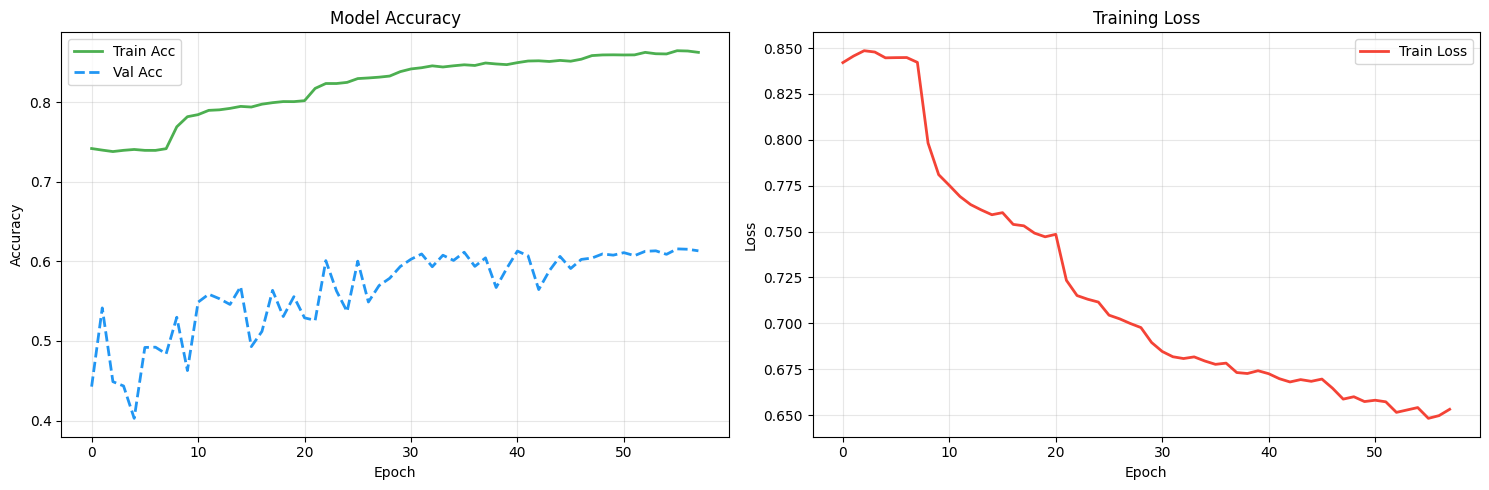


FINAL EVALUATION (Best Val Acc: 61.6%)


KeyboardInterrupt: 

In [8]:
# Cell 8: Training Visualization & Final Metrics
# ---------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# 1. Plot Training History
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy Plot
ax1.plot(history['train_acc'], label='Train Acc', color='#4CAF50', linewidth=2)
ax1.plot(history['val_acc'], label='Val Acc', color='#2196F3', linewidth=2, linestyle='--')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Loss Plot
ax2.plot(history['train_loss'], label='Train Loss', color='#F44336', linewidth=2)
ax2.set_title('Training Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 2. Final Evaluation on Best Model
print("\n" + "="*40)
print(f"FINAL EVALUATION (Best Val Acc: {best_val_acc:.1%})")
print("="*40)

# Load the best model weights
best_model_path = save_dir / "best_model_wavefront_aug.pt"
if best_model_path.exists():
    model.load_state_dict(torch.load(best_model_path))
    print(f"Loaded weights from {best_model_path}")

model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for mic, action, _, _ in val_loader:
        mic = mic.to(device)
        targets = (action - 1).to(device)
        logits = model(mic)
        preds = logits.argmax(dim=1)
        all_preds.extend(preds.cpu().tolist())
        all_targets.extend(targets.cpu().tolist())

class_names = ['UP', 'DOWN', 'LEFT', 'RIGHT']

# 3. Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(all_targets, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Best Model)')
plt.ylabel('Actual Direction')
plt.xlabel('Predicted Direction')
plt.show()

# 4. Detailed Report
print("\nClassification Report:")
print(classification_report(all_targets, all_preds, target_names=class_names))